# Image Editing with Prompt Engineering and Google Imagen / Stable Diffusion

## 1. Import Required Modules and Set Up Paths

In [25]:
import sys
import os
# project root directory
root_path = '/Users/suvz47/Code/Cursor/2 NIAT Demo/'
sys.path.append('/Users/suvz47/Code/Cursor/2 NIAT Demo/')
# to create values from config
import configparser
# for loading and using prompt engineering model
from llama_cpp import Llama
# for prompt template
from langchain_core.prompts import PromptTemplate

## 2. Load LLM Configuration from config.ini

In [26]:
# config values
config = configparser.ConfigParser()
config.read(root_path + 'config.ini')
#model folder
model_dir = config.get('LLM', 'model_dir_prompt')
#context window - how far the model can see in the messages
n_ctx = config.getint('LLM', 'n_ctx')
# batch size - how many prompts parllely
n_batch = config.getint('LLM', 'n_batch')
# max tokens
max_tokens = config.getint('LLM', 'max_tokens')
# how creative the LLM model is
temperature = config.getfloat('LLM', 'temperature')

## 3. Load GGUF Model with llama-cpp-python

In [27]:
model_files = [f for f in os.listdir(root_path + model_dir) if f.endswith('-00001-of-00002.gguf')]
assert model_files, f'No first split GGUF model found in {model_dir}/'
model_path = os.path.join(root_path + model_dir, model_files[0])
llm = Llama(
    model_path=model_path,
    n_ctx=n_ctx,
    n_batch=n_batch,
    verbose=False
)
print(f'Loaded editing LLM model: {model_path}')

llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80

Loaded editing LLM model: /Users/suvz47/Code/Cursor/2 NIAT Demo/models/prompt_engineering/qwen2.5-7b-instruct-q5_k_m-00001-of-00002.gguf


## 4. Prompt Template for Image Editing

In [28]:
prompt_template = PromptTemplate.from_template(
    """
You are an expert prompt engineer for AI image editing.

Your task is to rewrite the user's prompt to be more specific about the edits needed about an image, and slightly more detailed and descriptive.

Output the improved prompt inside <improved_prompt> and </improved_prompt> tags, and output only ONE improved prompt. Do not repeat or generate multiple improved prompts.

Now, here is the user prompt:
User prompt: {user_prompt}
<improved_prompt>
"""
)

In [29]:
def engineer_edit_prompt(user_prompt, max_tokens=None, temperature=None):
    if max_tokens is None:
        max_tokens = config.getint('LLM', 'max_tokens')
    if temperature is None:
        temperature = config.getfloat('LLM', 'temperature')
    prompt = (
        "<|im_start|>system\n"
        "You are a helpful assistant and an expert prompt engineer for AI image editing. "
        "Your task is to rewrite the user's prompt to be more specific about the edits needed about an image, and slightly more detailed and descriptive. "
        "Output only one improved prompt."
        "<|im_end|>\n"
        f"<|im_start|>user\n{user_prompt}<|im_end|>\n"
        "<|im_start|>assistant\n"
    )
    response = llm(prompt, max_tokens=max_tokens, temperature=temperature)
    text = response["choices"][0]["text"].strip()
    if "<improved_prompt>" in text and "</improved_prompt>" in text:
        text = text.split("<improved_prompt>",1)[1].split("</improved_prompt>",1)[0].strip()
    return text

## 5. Load Stable Diffusion Pipeline

In [30]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image

pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("mps")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 23.21it/s]


## 6. Select and Preprocess the Input Image

In [31]:
image_files = [f for f in os.listdir('output') if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise FileNotFoundError("No image files found in output directory")

for i, filename in enumerate(image_files, 1):
    print(f"{i}. {filename}")

choice = int(input(f"\nSelect image (1-{len(image_files)}): "))
image_path = os.path.join('output', image_files[choice - 1])
init_image = Image.open(image_path).convert("RGB").resize((512, 512))

1. 100mm_raw_camera_f28_professional_food_photo_of_sa_20250705_084247.png
2. perfectly_crafted_round_whole_cake_topped_with_a_g_20250705_084206.png
3. biscuits_on_a_table_20250705_084013.png


## 7. Apply Prompt Engineering

In [32]:
user_prompt = input("Enter your image editing prompt: ")
try:
    engineered_prompt = engineer_edit_prompt(user_prompt)
    print(f"\nEngineered prompt for editing:\n{engineered_prompt}\n")
except Exception as e:
    print(f"[Warning] LLM prompt engineering failed: {e}\nUsing original prompt.")
    engineered_prompt = user_prompt


Engineered prompt for editing:
Change the background color of the image to a solid red hue, ensuring that the entire background is uniformly red without any visible gradients or patterns.



## 8. Perform Image Editing and Save Output

In [33]:
images = pipe(prompt=engineered_prompt, image=init_image, strength=0.7, guidance_scale=8).images
output_path = f"output/EDITED_{os.path.basename(image_path)}"
images[0].save(output_path)
print(f"\nImage edited and saved as: {output_path}")

100%|██████████| 35/35 [00:09<00:00,  3.61it/s]



Image edited and saved as: output/EDITED_biscuits_on_a_table_20250705_084013.png


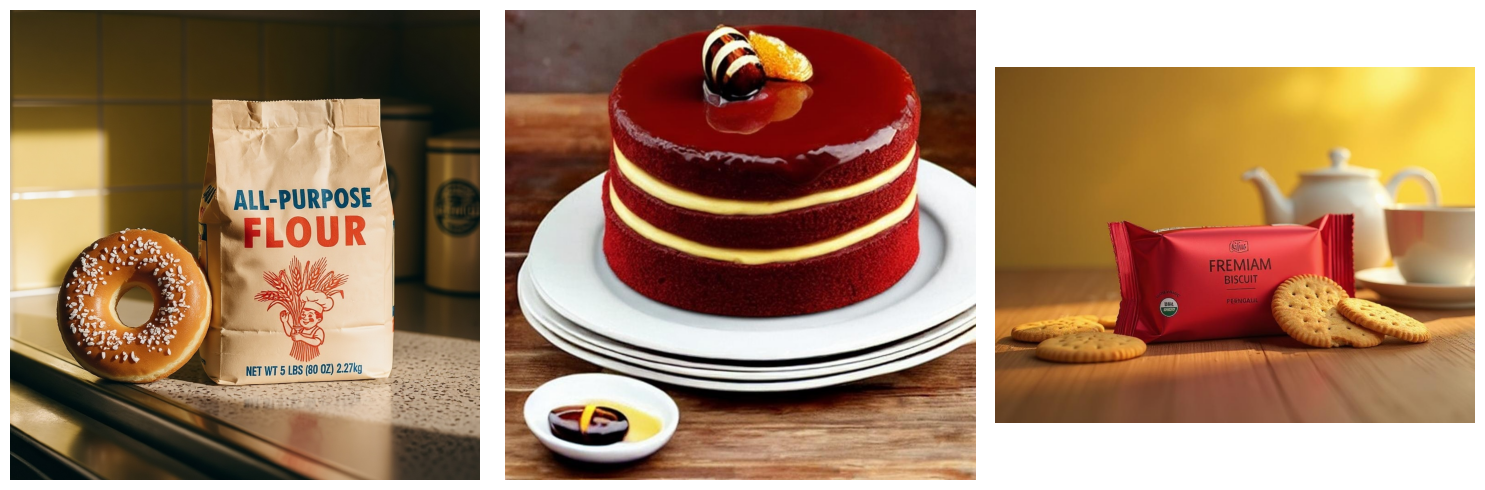

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import glob

# Get all images from output folder
output_dir = "/Users/suvz47/Code/Cursor/2 NIAT Demo/local_demo/output/edited images"
image_files = glob.glob(f"{output_dir}/*.png") + glob.glob(f"{output_dir}/*.jpg")

# Display images
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))
if len(image_files) == 1:
    axes = [axes]

for i, img_path in enumerate(image_files):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    # Remove title
    axes[i].axis('off')

plt.tight_layout()
plt.show()